# Changes in religious affiliation and attendance

Analysis based on data from the [CIRP Freshman Survey](https://heri.ucla.edu/cirp-freshman-survey/)

Copyright Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import thinkbayes2
import thinkplot

import statsmodels.formula.api as smf

Read the data.  Note: I transcribed these data manually from published documents, so data entry errors are possible.

In [2]:
df = pd.read_csv('heri18.csv', skiprows=2, index_col='year')
df[df.columns] /= 10
df.tail()

,noneall,fatherall,motherall,attendedall,nonemen,fathermen,mothermen,attendedmen,nonewomen,fatherwomen,motherwomen,attendedwomen,bornagain,evangelical
year,,,,,,,,,,,,,,
2013,24.6,17.1,12.1,72.7,26.9,16.2,12.0,70.3,22.6,17.9,12.1,74.8,NaN,NaN
2014,27.5,19.0,13.8,70.7,30.0,18.4,13.7,68.3,25.4,19.5,13.9,72.7,NaN,NaN
2015,29.6,16.6,16.4,69.5,31.8,NaN,NaN,67.8,27.7,NaN,NaN,70.8,NaN,NaN
2016,30.9,NaN,NaN,68.9,33.1,NaN,NaN,67.1,29.1,NaN,NaN,70.4,NaN,NaN
2017,30.2,NaN,NaN,69.2,31.9,NaN,NaN,67.7,28.8,NaN,NaN,70.4,NaN,NaN


Compute time variables for regression analysis, centered on 1966 (which makes the estimated intercept more interpretable).

In [3]:
df['time'] = df.index - 1966
df['time2'] = df.time**2

The following functions fits a regression model and uses a permutation method to estimate uncertainty due to random sampling.

In [4]:
def MakeErrorModel(df, y, formula, n=100):
    """Makes a model that captures sample error and residual error.

    df: DataFrame
    y: Series
    formula: string representation of the regression model
    n:     number of simulations to run

    returns: (fittedvalues, sample_error, total_error)
    """
    # make the best fit
    df['y'] = y
    results = smf.ols(formula, data=df).fit()
    fittedvalues = results.fittedvalues
    resid = results.resid    

    # permute residuals and generate hypothetical fits
    fits = []
    for i in range(n):
        df['y'] = fittedvalues + np.random.permutation(results.resid)
        fake_results = smf.ols(formula, data=df).fit()
        fits.append(fake_results.fittedvalues)

    # compute the variance of the fits
    fits = np.array(fits)
    sample_var = fits.var(axis=0)
    
    # add sample_var and the variance of the residuals
    total_var = sample_var + resid.var()

    # standard errors are square roots of the variances
    return fittedvalues, np.sqrt(sample_var), np.sqrt(total_var)

Plot a region showing a confidence interval.

In [5]:
def FillBetween(fittedvalues, stderr, **options):
    """Fills in the 95% confidence interval.
    
    fittedvalues: series
    stderr: standard error
    """
    low = fittedvalues - 2 * stderr
    high = fittedvalues + 2 * stderr
    thinkplot.FillBetween(fittedvalues.index, low, high, **options)

Plot a line of best fit, a region showing the confidence interval of the estimate and the predictive interval.

In [6]:
def PlotModel(y, fittedvalues, sample_error, total_error, **options):
    """Plots confidence intervals and the actual data.
    
    y: Series of actual data
    fittedvalues: Series of fitted values
    sample_error: Series of standard errors due to random sampling
    total_error: Series representing total error due to sampling and random variation
    options: dictional of options used to plot the data
    """
    FillBetween(fittedvalues, total_error, color='0.9')
    FillBetween(fittedvalues, sample_error, color='0.7')
    thinkplot.Plot(fittedvalues, color='0.5')
    thinkplot.Plot(y, **options)

In [7]:
def Plot(df, y, formula, **options):
    """Run a model and plot the results.
    
    df: DataFrame
    y: Series of actual data
    formula: Patsy string for the regression model
    options: dictional of options used to plot the data
    """
    fittedvalues, sample_error, total_error = MakeErrorModel(df, y, formula)
    PlotModel(y, fittedvalues, sample_error, total_error, **options)
    thinkplot.Config(xlim=[1965, 2017])

Seaborn provides aesthetic colors and graphical style.

In [9]:
import seaborn as sns
sns.set_style('whitegrid')
#sns.set_context('talk', font_scale=1.3)


Plot the fraction of respondents with no religious preference along with a quadratic model.

Writing heri18.1.png


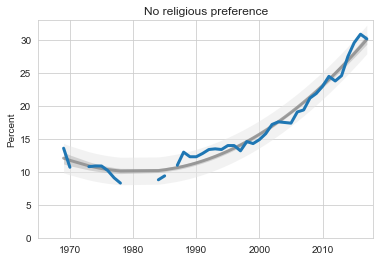

In [11]:
formula = 'y ~ time + time2'
y = df.noneall
Plot(df, y, formula, color='C0', alpha=1)
thinkplot.Config(title='No religious preference', 
                 ylabel='Percent', loc='upper left', 
                 xlim=[1965, 2018], ylim=[0, 33])
thinkplot.Save(root='heri18.1', clf=False, formats=['png'])

Fitting a quadratic model to percentages is a bit nonsensical, since percentages can't exceed 1.  It would probably be better to work in terms of log-odds, particularly if we are interested in forecasting what might happen after we cross the 50% line.  But for now the simple model is fine.

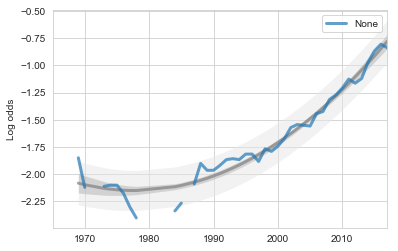

In [12]:
ps = df.noneall / 100
odds = ps / (1-ps)
log_odds = np.log(odds)
log_odds
Plot(df, log_odds, formula, color='C0', label='None')
thinkplot.Config(ylabel='Log odds')

Plot the fraction of students reporting attendance at religious services, along with a quadratic model.

Writing heri18.3.png


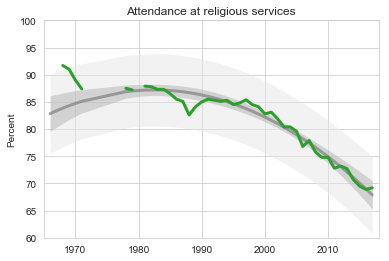

In [15]:
attend = df.attendedall
Plot(df, attend, formula, color='C2', alpha=1)
thinkplot.Config(title='Attendance at religious services', ylabel='Percent',
                 xlim=[1965, 2018], ylim=[60,100])
thinkplot.Save(root='heri18.3', clf=False, formats=['png'])

Plot the gender gap along with a quadratic model.

Writing heri18.2.png


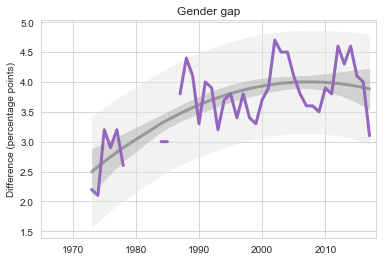

In [20]:
diff = df.nonemen - df.nonewomen
diff = diff.loc[1973:]
Plot(df, diff, formula, color='C4', alpha=1)
thinkplot.Config(title='Gender gap', ylabel='Difference (percentage points)',
                xlim=[1965, 2018])
thinkplot.Save(root='heri18.2', clf=False, formats=['png'])

To see whether the gender gap is still increasing, we can fit a quadatic model to the most recent data.

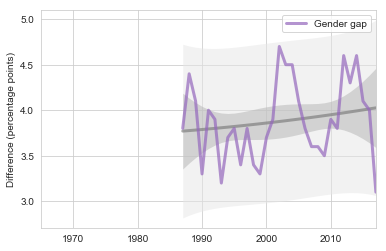

In [21]:
diff = df.nonemen - df.nonewomen
diff = diff.loc[1986:]
Plot(df, diff, formula, color='C4', label='Gender gap')
thinkplot.Config(ylabel='Difference (percentage points)')

A linear model for the most recent data suggests that the gap is probably still growing.

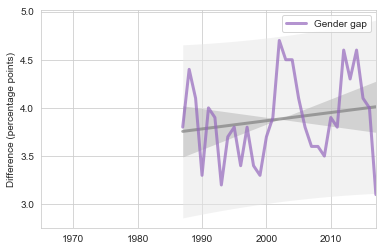

In [23]:
diff = df.nonemen - df.nonewomen
diff = diff.loc[1986:]
Plot(df, diff, 'y ~ time', color='C4', label='Gender gap')
thinkplot.Config(ylabel='Difference (percentage points)')